In [80]:
import pandas as pd

# Load the files
df_sentiment = pd.read_csv("nifty50.csv")
df_indicators = pd.read_csv("nifty50_all_indicators.csv")

# Rename columns to match
df_sentiment.rename(columns={'Date': 'Timestamp', 'Stock_Symbol': 'Symbol'}, inplace=True)

# Convert to datetime
df_sentiment['Timestamp'] = pd.to_datetime(df_sentiment['Timestamp'])
df_indicators['Timestamp'] = pd.to_datetime(df_indicators['Timestamp'])

# Remove timezone if any
df_sentiment['Timestamp'] = df_sentiment['Timestamp'].dt.tz_localize(None)
df_indicators['Timestamp'] = df_indicators['Timestamp'].dt.tz_localize(None)

# Merge on both Timestamp and Symbol
df_merged = pd.merge(
    df_indicators,
    df_sentiment[['Timestamp', 'Symbol', 'Reversal']],
    on=['Timestamp', 'Symbol'],
    how='inner'
)

# Save result
df_merged.to_csv("nifty50_indicators_with_sentiment.csv", index=False)
print("✅ Merged successfully on Timestamp & Symbol — rows:", df_merged.shape[0])


✅ Merged successfully on Timestamp & Symbol — rows: 940


In [82]:
df_merged.shape

(940, 94)

In [84]:
df_sentiment.shape

(940, 4)

In [86]:
dfsaveddf=df_merged.copy()


In [88]:
from sklearn.preprocessing import LabelEncoder

# Define X and y
df = dfsaveddf.copy()  # your saved merged DataFrame
X = df.drop(columns=["Reversal", "Timestamp", "Symbol"])  # drop target & ID columns
y = LabelEncoder().fit_transform(df["Reversal"])


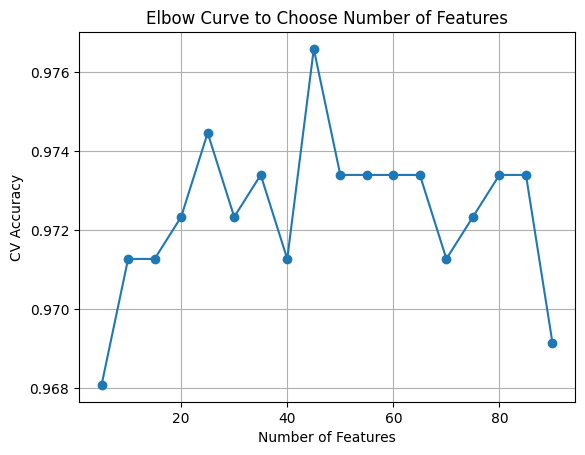

In [92]:
from sklearn.feature_selection import SelectKBest
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score
import matplotlib.pyplot as plt

scores = []
feature_counts = list(range(5, len(X.columns)+1, 5))  # test every 5 features

for k in feature_counts:
    X_kbest = SelectKBest(k=k).fit_transform(X, y)
    score = cross_val_score(RandomForestClassifier(), X_kbest, y, cv=5).mean()
    scores.append(score)

plt.plot(feature_counts, scores, marker='o')
plt.xlabel("Number of Features")
plt.ylabel("CV Accuracy")
plt.title("Elbow Curve to Choose Number of Features")
plt.grid(True)
plt.show()


In [29]:
#Model-Based Feature Importance (Random Forest)
from sklearn.ensemble import RandomForestClassifier

rf = RandomForestClassifier(n_estimators=100, random_state=42)
rf.fit(X, y)

rf_importances = pd.Series(rf.feature_importances_, index=X.columns).sort_values(ascending=False)

print("Top 40 Features by Random Forest Importance:")
print(rf_importances.head(40))


Top 40 Features by Random Forest Importance:
volatility_kcp               0.159587
trend_cci                    0.090724
momentum_stoch_rsi           0.077154
momentum_stoch_rsi_k         0.075734
momentum_stoch               0.071624
momentum_wr                  0.066944
volatility_bbp               0.066016
volume_em                    0.051793
momentum_stoch_signal        0.046609
momentum_ppo_hist            0.032625
trend_vortex_ind_pos         0.020505
trend_adx_neg                0.019541
trend_macd_diff              0.018184
trend_vortex_ind_diff        0.016955
momentum_rsi                 0.016725
trend_aroon_up               0.016374
trend_aroon_down             0.015481
trend_stc                    0.010669
volatility_dcp               0.009994
trend_adx_pos                0.009839
momentum_roc                 0.009547
momentum_stoch_rsi_d         0.008548
volatility_kcli              0.006898
volatility_ui                0.004280
trend_macd                   0.004022
trend

In [31]:
top_40_features = rf_importances.head(40)
top_40_feature_names = top_40_features.index.tolist()

In [33]:
top_40_feature_names

['volatility_kcp',
 'trend_cci',
 'momentum_stoch_rsi',
 'momentum_stoch_rsi_k',
 'momentum_stoch',
 'momentum_wr',
 'volatility_bbp',
 'volume_em',
 'momentum_stoch_signal',
 'momentum_ppo_hist',
 'trend_vortex_ind_pos',
 'trend_adx_neg',
 'trend_macd_diff',
 'trend_vortex_ind_diff',
 'momentum_rsi',
 'trend_aroon_up',
 'trend_aroon_down',
 'trend_stc',
 'volatility_dcp',
 'trend_adx_pos',
 'momentum_roc',
 'momentum_stoch_rsi_d',
 'volatility_kcli',
 'volatility_ui',
 'trend_macd',
 'trend_psar_up_indicator',
 'volume_fi',
 'trend_vortex_ind_neg',
 'others_dlr',
 'trend_dpo',
 'momentum_tsi',
 'trend_aroon_ind',
 'trend_psar_down_indicator',
 'volatility_dcw',
 'volatility_bbw',
 'others_dr',
 'momentum_uo',
 'trend_kst',
 'volume_mfi',
 'trend_kst_sig']

In [68]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedKFold, GridSearchCV,StratifiedShuffleSplit

In [70]:
X = df[top_40_feature_names]
y = LabelEncoder().fit_transform(df["Reversal"])

# Define F-beta scorer
fbeta_05 = make_scorer(fbeta_score, beta=0.5, average='weighted')

# Stratified CV setup
stratified_cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Define param grid
param_grid = {
    'n_estimators': [100, 200],
    'max_depth': [5, 10, None],
    'min_samples_split': [2, 5],
    'min_samples_leaf': [1, 2],
    'max_features': ['sqrt', 'log2']
}

# Initialize model
rf = RandomForestClassifier(random_state=42)

# Grid search
grid = GridSearchCV(
    estimator=rf,
    param_grid=param_grid,
    scoring=fbeta_05,
    cv=stratified_cv,
    n_jobs=-1,
    verbose=1,
    return_train_score=False
)
grid.fit(X, y)

# Best model
best_rf = grid.best_estimator_
print("✅ Best Parameters:", grid.best_params_)

# Print F0.5 scores across all combinations
print("\n📊 F0.5 Scores per Fold Set:")
for idx, score in enumerate(grid.cv_results_['mean_test_score']):
    print(f"  Fold Set {idx+1}: {score:.4f}")

print(f"\n🏆 Best Mean F0.5 Score: {grid.best_score_:.4f}")

# ➕ Stratified holdout split for classification report
sss = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)
for train_idx, test_idx in sss.split(X, y):
    X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
    y_train, y_test = y[train_idx], y[test_idx]

# Fit and evaluate
best_rf.fit(X_train, y_train)
y_pred = best_rf.predict(X_test)

print("\n📋 Classification Report on Stratified Holdout Set:")
print(classification_report(y_test, y_pred))

Fitting 5 folds for each of 48 candidates, totalling 240 fits
✅ Best Parameters: {'max_depth': None, 'max_features': 'log2', 'min_samples_leaf': 1, 'min_samples_split': 5, 'n_estimators': 200}

📊 F0.5 Scores per Fold Set:
  Fold Set 1: 0.9735
  Fold Set 2: 0.9746
  Fold Set 3: 0.9757
  Fold Set 4: 0.9757
  Fold Set 5: 0.9746
  Fold Set 6: 0.9767
  Fold Set 7: 0.9756
  Fold Set 8: 0.9757
  Fold Set 9: 0.9693
  Fold Set 10: 0.9715
  Fold Set 11: 0.9714
  Fold Set 12: 0.9714
  Fold Set 13: 0.9724
  Fold Set 14: 0.9735
  Fold Set 15: 0.9735
  Fold Set 16: 0.9735
  Fold Set 17: 0.9746
  Fold Set 18: 0.9757
  Fold Set 19: 0.9746
  Fold Set 20: 0.9757
  Fold Set 21: 0.9756
  Fold Set 22: 0.9757
  Fold Set 23: 0.9746
  Fold Set 24: 0.9757
  Fold Set 25: 0.9746
  Fold Set 26: 0.9767
  Fold Set 27: 0.9756
  Fold Set 28: 0.9767
  Fold Set 29: 0.9767
  Fold Set 30: 0.9756
  Fold Set 31: 0.9767
  Fold Set 32: 0.9767
  Fold Set 33: 0.9746
  Fold Set 34: 0.9757
  Fold Set 35: 0.9746
  Fold Set 36: 0.

In [72]:
X = df[top_40_feature_names]
y = LabelEncoder().fit_transform(df["Reversal"])

# Train final model on all data using best hyperparameters
final_rf = RandomForestClassifier(
    n_estimators=200,
    max_depth=None,
    max_features='log2',
    min_samples_split=5,
    min_samples_leaf=1,
    random_state=42
)

final_rf.fit(X, y)

RandomForestClassifier(max_features='log2', min_samples_split=5,
                       n_estimators=200, random_state=42)

In [74]:
import pickle

In [76]:
with open("rf_f0.5_final.pkl", "wb") as f:
    pickle.dump(final_rf, f)